In [5]:
import multiprocessing
from pymatgen.analysis.structure_matcher import StructureMatcher
from functools import partial 
from tqdm import tqdm
import json
from pymatgen.core import Structure
import numpy as np
import concurrent.futures
import concurrent.futures
from tqdm import tqdm
import sys
sys.path.append('../Modules')
from concurrent_structure_adding import compare_and_add


# Failed Multi

In [5]:
def load_json(filename):
    """Helper function to load JSON data from a file."""
    with open(filename, 'r') as f:
        return json.load(f)

def process_wrapper(data, existing_dataset, energy_tol, force_tol, stress_tol):
    return compare_and_add(data, existing_dataset, energy_tol, force_tol, stress_tol)

def compare_and_add(data_point, existing_dataset, energy_tol, force_tol, stress_tol):
    print(data_point)
    print(data_point.keys())
    structure = data_point['structure']
    energy = data_point['energy']
    forces = data_point['forces']
    stresses = data_point['stresses']
    
    matcher = StructureMatcher()
    
    if len(existing_dataset) == 0:
        return data_point
    
    for existing_data in existing_dataset:
        if matcher.fit(existing_data['structure'], structure):
            energy_diff = abs(existing_data['energy'] - energy)
            forces_diff = max(abs(existing_data['forces'] - forces))
            stress_diff = max(abs(existing_data['stresses'] - stresses))
            
            if energy_diff < energy_tol and forces_diff < force_tol and stress_diff < stress_tol:
                return None  # Too similar, don't add
    
    return data_point  # Different enough, add this data point

def process_data_in_parallel(json_files, existing_dataset, energy_tol, force_tol, stress_tol):
    # First, load all JSON data from files
    json_data = [load_json(filename) for filename in json_files]
    
    partial_process = partial(process_wrapper, existing_dataset=existing_dataset, 
                              energy_tol=energy_tol, force_tol=force_tol, stress_tol=stress_tol)

    multiprocessing.set_start_method('fork', force=True)

    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = list(tqdm(pool.imap(partial_process, json_data), total=len(json_data)))

    new_dataset = [result for result in results if result is not None]
    print(f"New dataset size: {len(new_dataset)} entries")
    
    return new_dataset

In [15]:
json_files = ['../Archived_Vasp_Jobs/combined_vacancies_unshuffled_vcrti.json']
existing_dataset = []  # Existing dataset to compare against
energy_tol = 1e-3  # Example tolerance for energy
force_tol = 1e-2  # Example tolerance for forces
stress_tol = 1e-2  # Example tolerance for stresses

new_dataset = process_data_in_parallel(json_files, existing_dataset, energy_tol, force_tol, stress_tol)
print(f"Final dataset size: {len(new_dataset)} entries")

  0%|          | 0/1 [00:00<?, ?it/s]

# Serial

In [2]:
def batch_load_json(json_files):
    # Load all JSON data from files and combine into a single list of data points
    json_data = []
    for filename in json_files:
        data = load_json(filename)
        json_data.extend(data.values())  # Get all data points from the JSON and add to the list
    return json_data

def load_json(filename):
    """Helper function to load JSON data from a file."""
    with open(filename, 'r') as f:
        return json.load(f)

def _compare_and_add(data_point, existing_dataset, energy_tol, force_tol, stress_tol,counters):
    #print("Processing data point...")
    #print("Data point keys:", data_point.keys())

    # Convert structure data to a Structure object if it isn't one already
    #if isinstance(data_point['structure'], str):
    structure = Structure.from_dict(data_point['structure'])
    #else:
    #    structure = data_point['structure']

    energy = data_point['energy_per_atom']
    forces = np.array(data_point['force'])
    stresses = np.array(data_point['stress'])

    matcher = StructureMatcher()

    if len(existing_dataset) == 0:
        print("Existing dataset is empty, adding data point.")
        counters['accepted'] += 1
        return data_point

    #print(f"Comparing with {len(existing_dataset)} existing data points.")
    for idx, existing_data in enumerate(existing_dataset):
        existing_structure = Structure.from_dict(existing_data['structure'])
        #if isinstance(existing_structure, str):
            #existing_structure = Structure.from_dict(existing_structure)
        
        if matcher.fit(existing_structure, structure):
            energy_diff = abs(existing_data['energy_per_atom'] - energy)
            forces_diff = np.max(np.abs(np.array(existing_data['force']) - forces))
            stress_diff = np.max(np.abs(np.abs(np.array(existing_data['stress'])) - stresses))
            
            if energy_diff < energy_tol and forces_diff < force_tol and stress_diff < stress_tol:
                #print(f"Data point is too similar to existing data point {idx + 1}, skipping.")
                counters['rejected'] += 1
                return None  # Too similar, don't add

    counters['accepted'] += 1
    #print("Data point is different enough, adding to new dataset.")
    return data_point  # Different enough, add this data point

def process_data_serially(json_data, existing_dataset, energy_tol, force_tol, stress_tol):
    
    counters = {'accepted' : 0, 'rejected' : 0}
    
    # Process each data point serially with a progress bar
    for data in tqdm(json_data, desc="Processing Data", unit="file"):
        result = compare_and_add(data, existing_dataset, energy_tol, force_tol, stress_tol, counters)
        if result:
            existing_dataset.append(result)
    print(f"Accepted {counters['accepted']} new data points, rejected {counters['rejected']}.")

    
    print(f"New dataset size: {len(new_dataset)} entries")
    
    return existing_dataset


def process_data_concurrent(json_data, existing_dataset, energy_tol, force_tol, stress_tol):
    counters = {'accepted': 0, 'rejected': 0}
    
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = []
        for data in json_data:
            futures.append(executor.submit(compare_and_add, data, existing_dataset, energy_tol, force_tol, stress_tol))
        
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing Data", unit="file"):
            data_point, status = future.result()
            if data_point:
                existing_dataset.append(data_point)
            counters[status] += 1

    print(f"Accepted {counters['accepted']} new data points, rejected {counters['rejected']}.")
    print(f"New dataset size: {len(existing_dataset)} entries")
    
    return existing_dataset


In [29]:
json_files = ['../Archived_Vasp_Jobs/combined_vacancies_unshuffled_vcrti.json']  # List of JSON file names to process
existing_dataset = []  # Existing dataset to compare against
energy_tol = 1e-3  # Example tolerance for energy
force_tol = 1e-2  # Example tolerance for forces
stress_tol = 1e-3  # Example tolerance for stresses

In [10]:
# Load JSON data
json_data = batch_load_json(json_files)
print(f"Loaded {len(json_data)} data points from JSON files.")

Loaded 64237 data points from JSON files.


In [59]:
if __name__ == '__main__':
    # Process data serially
    existing_dataset = []
    new_dataset = process_data_concurrent(json_data, existing_dataset, energy_tol, force_tol, stress_tol)
    print(f"Final dataset size: {len(new_dataset)} entries")

Processing Data:   2%|▏         | 1047/64237 [02:08<2:09:38,  8.12file/s]


# t-SNE

Converting frames: 100%|██████████| 64237/64237 [00:05<00:00, 11924.53frame/s]


Converted 64237 frames into feature vectors.


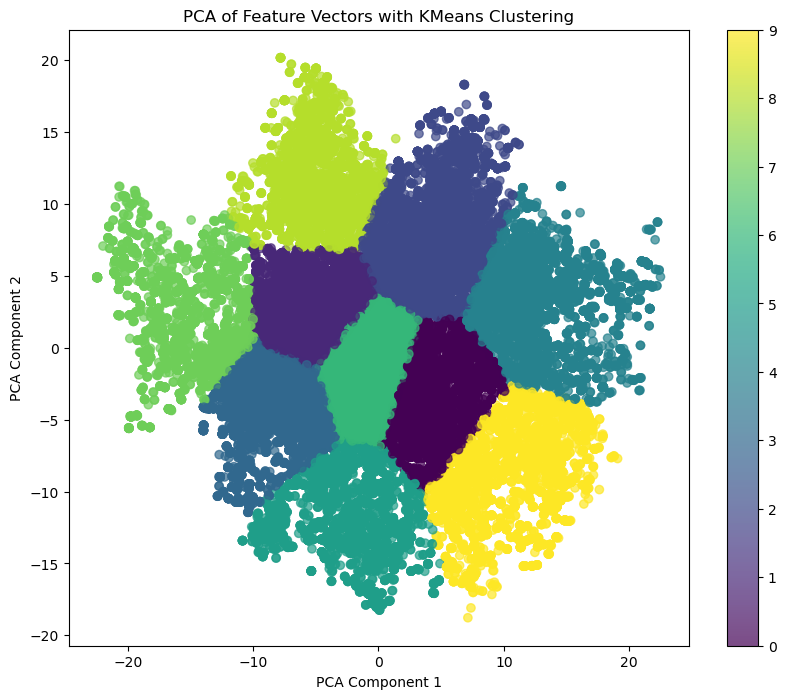

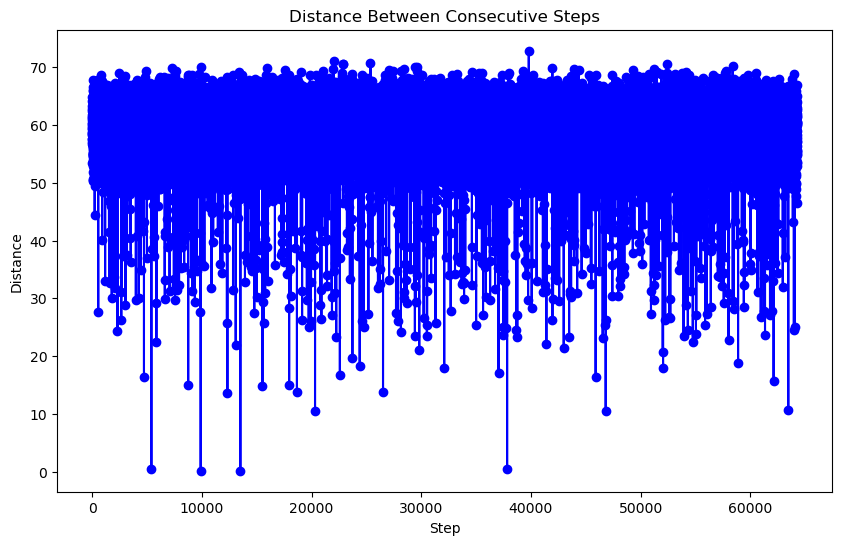

In [3]:
from ase.io import read 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from ase.io import read
from tqdm import tqdm

def atoms_to_vector(atoms):
    lattice_vector = atoms.get_cell().array.flatten()
    atomic_positions = atoms.get_positions().flatten()
    element_types = np.array([atom.number for atom in atoms], dtype=np.float32)
    return np.concatenate([lattice_vector, atomic_positions, element_types])

def frame_to_vector(atoms):
    structure_vector = atoms_to_vector(atoms)
    try:
        energy = np.array([atoms.get_potential_energy()], dtype=np.float32)
        forces = np.array(atoms.get_forces()).flatten()
        stress = np.array(atoms.get_stress()).flatten()
    except:
        energy = np.array([atoms.info['REF_energy']], dtype=np.float32)
        forces = np.array(atoms.todict()['REF_force']).flatten()
        stress = np.array(atoms.info['REF_stress']).flatten()
    
    return np.concatenate([structure_vector, energy, forces, stress])

def load_and_convert_extxyz(filename):
    feature_vectors = []
    atoms_frames = read(filename, index=":")  # Read all frames
    for atoms in tqdm(atoms_frames, desc="Converting frames", unit="frame"):
        feature_vector = frame_to_vector(atoms)
        feature_vectors.append(feature_vector)
    return feature_vectors, atoms_frames

def visualize_similarity(feature_vectors):
    # Reduce dimensionality with PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(feature_vectors)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=10, random_state=42)
    cluster_labels = kmeans.fit_predict(reduced_data)

    # Plot the PCA-reduced data with cluster labels
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title('PCA of Feature Vectors with KMeans Clustering')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

def plot_time_series_similarity(feature_vectors):
    # Compute distances between consecutive steps
    distances = [np.linalg.norm(feature_vectors[i+1] - feature_vectors[i]) for i in range(len(feature_vectors)-1)]

    # Plot the distance over steps
    plt.figure(figsize=(10, 6))
    plt.plot(distances, marker='o', linestyle='-', color='b')
    plt.title('Distance Between Consecutive Steps')
    plt.xlabel('Step')
    plt.ylabel('Distance')
    plt.show()

if __name__ == '__main__':
    # Specify the extxyz file
    #data = '../Archived_Vasp_Jobs/vcrtiwzr_ase_vac_full.extxyz'
    data = '../Archived_Vasp_Jobs/vcrti_vac_conv.extxyz'

    # Convert all frames in the extxyz file to feature vectors
    feature_vectors, atoms_frames = load_and_convert_extxyz(data)
    print(f"Converted {len(feature_vectors)} frames into feature vectors.")

    # Visualize similarity using PCA and clustering
    visualize_similarity(feature_vectors)

    # Plot time-series similarity (distances between consecutive steps)
    plot_time_series_similarity(feature_vectors)



Converting frames: 100%|██████████| 64237/64237 [00:05<00:00, 11672.25frame/s]


Converted 64237 frames into feature vectors.


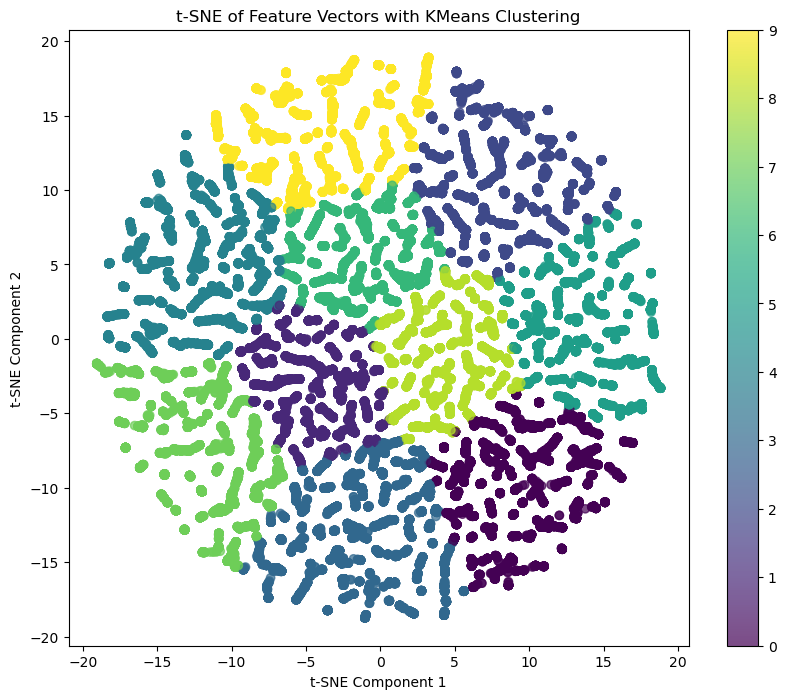

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from ase.io import read
from tqdm import tqdm

def visualize_similarity_tsne(feature_vectors):
    # Reduce dimensionality with t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
    tsne_results = tsne.fit_transform(np.array(feature_vectors))

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=10, random_state=42)
    cluster_labels = kmeans.fit_predict(tsne_results)

    # Plot the t-SNE results with cluster labels
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title('t-SNE of Feature Vectors with KMeans Clustering')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

if __name__ == '__main__':
    # Specify the extxyz file
    #extxyz_file = '../Archived_Vasp_Jobs/vcrti_neb_ase_all.extxyz'  # Replace with your actual extxyz file path
    #extxyz_file = '../Archived_Vasp_Jobs/vcrtiwzr_ase_vac_full.extxyz'
    extxyz_file = '../Archived_Vasp_Jobs/vcrti_vac_conv.extxyz'


    # Convert all frames in the extxyz file to feature vectors
    feature_vectors, atoms_frames = load_and_convert_extxyz(extxyz_file)
    print(f"Converted {len(feature_vectors)} frames into feature vectors.")

    # Visualize similarity using t-SNE and clustering
    visualize_similarity_tsne(feature_vectors)

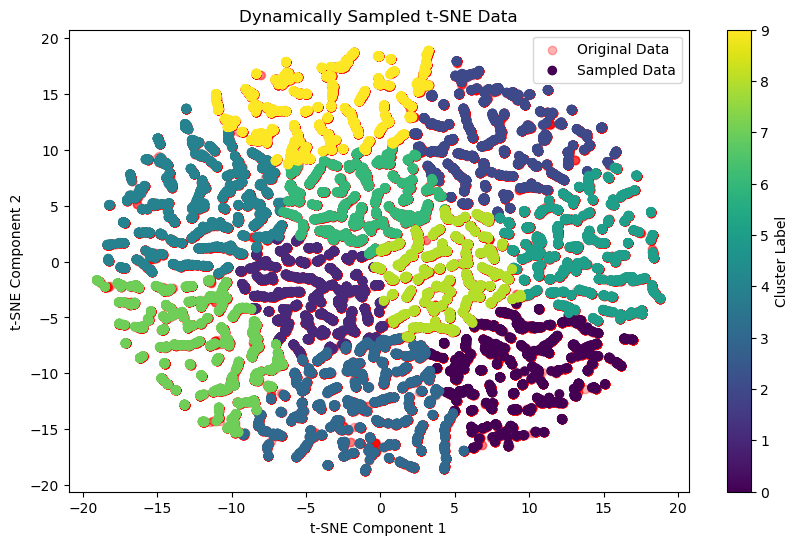

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Assume tsne_results and cluster_labels are already generated from your provided code
# tsne_results = your t-SNE transformed data
# cluster_labels = the cluster labels from KMeans

def dynamic_sampling(tsne_results, cluster_labels, sampling_factor=0.1):
    unique_clusters = np.unique(cluster_labels)
    sampled_indices = []

    for cluster in unique_clusters:
        # Get indices of data points in the current cluster
        cluster_indices = np.where(cluster_labels == cluster)[0]
        
        # Calculate the number of samples to take from this cluster
        n_samples = int(len(cluster_indices) * sampling_factor)
        if n_samples == 0:
            n_samples = 1  # Ensure at least one sample from each cluster

        # Randomly sample indices from the cluster
        sampled_indices.extend(np.random.choice(cluster_indices, n_samples, replace=False))

    # Get the sampled data
    sampled_tsne_data = tsne_results[sampled_indices]
    
    return sampled_tsne_data, sampled_indices

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(np.array(feature_vectors))

# Apply KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(tsne_results)

# Define the sampling factor (e.g., 10% of each cluster)
sampling_factor = 0.25  # Adjust based on how much you want to sample from each cluster

# Apply dynamic sampling
sampled_tsne_data, sampled_indices = dynamic_sampling(tsne_results, cluster_labels, sampling_factor)

# Visualize the dynamically sampled t-SNE data
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c='red', alpha=0.3, label="Original Data")
plt.scatter(sampled_tsne_data[:, 0], sampled_tsne_data[:, 1], c=cluster_labels[sampled_indices], cmap='viridis', label="Sampled Data")
plt.title("Dynamically Sampled t-SNE Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label="Cluster Label")
plt.legend()
plt.show()

# The sampled_indices can now be used to select the corresponding original feature vectors
sampled_feature_vectors = [feature_vectors[i] for i in sampled_indices]

In [7]:
print(f"Sampled {len(sampled_feature_vectors)} feature vectors from the original data consisting of {len(feature_vectors)} data points.")


Sampled 16056 feature vectors from the original data consisting of 64237 data points.


In [8]:
from ase.io import write

def save_sampled_atoms_to_extxyz(atoms_frames, sampled_indices, output_file):
    """
    Save sampled Atoms objects to an extxyz file.

    Parameters:
    - atoms_frames (list): List of ASE Atoms objects corresponding to the original dataset.
    - sampled_indices (list): List of indices indicating which Atoms objects to save.
    - output_file (str): Path to the output extxyz file.
    """
    # Extract the sampled Atoms objects using the sampled_indices
    sampled_atoms = [atoms_frames[i] for i in sampled_indices]

    # Write the selected Atoms objects to an extxyz file
    write(output_file, sampled_atoms, format='extxyz')
    print(f"Sampled extxyz file saved to {output_file}")

# Example usage:
# Let's assume `sampled_indices` is a list of indices from the dynamic sampling
# and `atoms_frames` is the list of all Atoms objects loaded from the original extxyz file.
output_file = 'ase_vcrti_vac_sampled_25per.extxyz'
save_sampled_atoms_to_extxyz(atoms_frames, sampled_indices, output_file)

Sampled extxyz file saved to ase_vcrti_vac_sampled_25per.extxyz


In [11]:
from pymatgen.io.vasp.outputs import Outcar

outcar_path = '../Archived_Vasp_Jobs/VCrTiWZr_Summit/Fixed-Encut-KPoints/Post_VASP/gen4-vac/supercell_gen4_comp44_struct2_vac_site0_start/OUTCAR-9'


outcar = Outcar(outcar_path)

dict_keys(['@module', '@class', 'efermi', 'run_stats', 'magnetization', 'charge', 'total_magnetization', 'nelect', 'is_stopped', 'drift', 'ngf', 'sampling_radii', 'electrostatic_potential', 'onsite_density_matrices'])
